In [1]:
import os
import sys
os.environ["OMP_NUM_THREADS"] = "11"
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "11" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "11" # export NUMEXPR_NUM_THREADS=6
os.environ["NUMBA_CACHE_DIR"]='/tmp/numba_cache'
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse
import h5py

import tensorflow as tf
import matplotlib.pyplot as plt
import scanpy as sc

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Load data

In [2]:
with h5py.File('dogma_cite_asap.h5', 'r') as f:
    print(f.keys())
    peak_names = np.array(f['peak_names'], dtype='S32').astype(str)
    ADT_names = np.array(f['ADT_names'], dtype='S32').astype(str)
    gene_names = np.array(f['gene_names'], dtype='S32').astype(str)
    
    # Count matrices of three modalities: X for genes, Y for ADT, and Z for peaks.
    X = sp.sparse.csc_matrix(
        (np.array(f['RNA.data'], dtype=np.float32), 
         np.array(f['RNA.indices'], dtype=np.int32),
         np.array(f['RNA.indptr'], dtype=np.int32)
        ), 
        shape = np.array(f['RNA.shape'], dtype=np.int32)).tocsc().astype(np.float32)
    Y = np.array(f['ADT'], dtype=np.float32)
    Z = sp.sparse.csc_matrix(
        (np.array(f['peaks.data'], dtype=np.float32),
         np.array(f['peaks.indices'], dtype=np.int32),
         np.array(f['peaks.indptr'], dtype=np.int32)
        ), 
        shape = np.array(f['peaks.shape'], dtype=np.int32)).tocsc().astype(np.float32)
    cell_types = np.array(f['cell_types'], dtype='S32').astype(str)
    
    # The covariate matrix, the last column is the ids of datasets
    batches = np.array(f['batches'], dtype=np.float32)
    id_datasets = batches[:,-1]
    
    # The indices of features that are observed in each dataset.
    id_X_dogma = np.array(f['id_X_dogma'], dtype=np.int32)
    id_Y_dogma = np.array(f['id_Y_dogma'], dtype=np.int32)
    id_Z_dogma = np.array(f['id_Z_dogma'], dtype=np.int32)    
    id_X_cite = np.array(f['id_X_cite'], dtype=np.int32)
    id_Y_cite = np.array(f['id_Y_cite'], dtype=np.int32)
    id_Y_asap = np.array(f['id_Y_asap'], dtype=np.int32)
    id_Z_asap = np.array(f['id_Z_asap'], dtype=np.int32)
    
    # The sample size
    sample_sizes = np.array(f['sample_sizes'], dtype=np.int32)
    

# Count peaks in each chromosome (assuming they are ordered)
chunk_atac = np.array([
    np.sum(np.char.startswith(peak_names, 'chr%d-'%i)) for i in range(1,23)
    ], dtype=np.int32)
dim_input_arr = np.array([len(gene_names),len(ADT_names),len(peak_names)])
print(dim_input_arr)
    
# Preprocess the data
X = X.toarray()
X[batches[:,-1]!=2,:] = np.log1p(X[batches[:,-1]!=2,:]/np.sum(X[batches[:,-1]!=2,:], axis=1, keepdims=True)*1e4)
Y = np.log1p(Y/np.sum(Y, axis=1, keepdims=True)*1e4)
Z[Z>0.] = 1.
Z = Z.toarray()
data = np.c_[X, Y, Z]
conditions = batches[:,-1]

# The masks indicate missing pattern for three datasets.
# -1 means missing and 0 means observed.
masks = - np.ones((3, np.sum(dim_input_arr)), dtype=np.float32)
masks[0,id_X_dogma] = 0.
masks[0,id_Y_dogma+dim_input_arr[0]] = 0.
masks[0,id_Z_dogma+np.sum(dim_input_arr[:2])] = 0.
masks[1,id_X_cite] = 0.
masks[1,id_Y_cite+dim_input_arr[0]] = 0.
masks[2,id_Y_asap+dim_input_arr[0]] = 0.
masks[2,id_Z_asap+np.sum(dim_input_arr[:2])] = 0.
masks = tf.convert_to_tensor(masks, dtype=tf.float32)

<KeysViewHDF5 ['ADT', 'ADT_names', 'RNA.data', 'RNA.indices', 'RNA.indptr', 'RNA.shape', 'batches', 'cell_ids', 'cell_types', 'gene_names', 'id_X_cite', 'id_X_dogma', 'id_Y_asap', 'id_Y_cite', 'id_Y_dogma', 'id_Z_asap', 'id_Z_dogma', 'peak_names', 'peaks.data', 'peaks.indices', 'peaks.indptr', 'peaks.shape', 'sample_sizes']>
[ 3660   227 38711]


# Set up config for model training

In [3]:
import sys; sys.path.insert(0, '..') # add parent folder path if not installed via PyPI
import scVAEIT
print(scVAEIT.__version__)

from scVAEIT.VAEIT import VAEIT
path_root = 'result/test8/'

config = {
    # Dimension of input features for [RNA, ADT, peaks]
    'dim_input_arr': dim_input_arr,

    # Blocks for [RNA, ADT, peaks at chr1, ... peaks at chr22]
    'dim_block': np.append([len(gene_names),len(ADT_names)], chunk_atac), # input dimension of blocks
    'dist_block':['NB','NB'] + ['Bernoulli' for _ in chunk_atac], # distributions of blocks
    'dim_block_enc':np.array([256, 128] + [16 for _ in chunk_atac]), # dimension of first layer of the encoder
    'dim_block_dec':np.array([256, 128] + [16 for _ in chunk_atac]), # dimension of first layer of the decoder
    'block_names':np.array(['rna', 'adt'] + ['atac' for _ in range(len(chunk_atac))]), # names of blocks
    'uni_block_names':np.array(['rna','adt','atac']), # names for modalities
    'dim_block_embed':np.array([16, 8] + [1 for _ in range(len(chunk_atac))])*2, # mask embedding dimension

    # Internal network structure
    'dimensions':[256], # dimension of latent layers of encoder; the reversed is used for decoder
    'dim_latent':32, # the latent dimension bewteen the encoder and decoder
    
    # Weights
    'beta_unobs':2./3., # weight for masked out observation; weight for observerd values will be 1-beta_unobs.
    'beta_modal':np.array([0.14,0.85,0.01]), # weights for 3 modalities

    # Masking probability
    "p_feat" : 0.2, # probablity of randomly masking out an entry
    "p_modal" : np.ones(3)/3, # probability of masking out the 3 modalities
    
    'gamma':lambda epoch: 2 * 0.8 ** (epoch / 50) # MMD loss to correct strong batch effects of multiple datasets
}


batches_cate = batches
batches_cont = None


model = VAEIT(config, data, 
                masks, id_datasets, 
                batches_cate, batches_cont, conditions)

1.0.0
namespace(beta_kl=2.0, beta_reverse=0.0, beta_modal=array([0.14, 0.85, 0.01]), p_modal=array([0.33333333, 0.33333333, 0.33333333]), uni_block_names=array(['rna', 'adt', 'atac'], dtype='<U4'), block_names=array(['rna', 'adt', 'atac', 'atac', 'atac', 'atac', 'atac', 'atac',
       'atac', 'atac', 'atac', 'atac', 'atac', 'atac', 'atac', 'atac',
       'atac', 'atac', 'atac', 'atac', 'atac', 'atac', 'atac', 'atac'],
      dtype='<U4'), dist_block=array(['NB', 'NB', 'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli',
       'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli',
       'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli',
       'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli',
       'Bernoulli', 'Bernoulli', 'Bernoulli'], dtype='<U9'), dim_block=array([3660,  227, 3939, 3156, 2531, 1463, 1920, 2491, 1979, 1577, 1515,
       1875, 1994, 2152,  881, 1439, 1250, 1462, 2103,  696, 1912, 1033,
        492,  851]), dim_block_enc=array([2

In [4]:
hist = model.train(
        num_epoch=300, batch_size=512, save_every_epoch=50,
        verbose=True, checkpoint_dir=path_root+'checkpoint/')

Train - Start of epoch 1
60/60 [==============================] - 26s 426ms/step - Reconstructed Loss: 404.4719
Epoch 1, Time elapsed: 0.43 minutes
          total, obs_rna, obs_adt, obs_atac, unobs_rna, unobs_adt, unobs_atac,      kl,     mmd
train :  432.07,   78.90,  112.14,   37.66,   64.49,   90.72,   32.68,   12.54,    2.94
Train - Start of epoch 2
60/60 [==============================] - 10s 163ms/step - Reconstructed Loss: 358.3354
Epoch 2, Time elapsed: 0.59 minutes
          total, obs_rna, obs_adt, obs_atac, unobs_rna, unobs_adt, unobs_atac,      kl,     mmd
train :  358.15,   64.30,  103.99,   26.77,   51.70,   83.53,   22.42,    2.93,    2.50
Train - Start of epoch 3
60/60 [==============================] - 10s 161ms/step - Reconstructed Loss: 353.7995
Epoch 3, Time elapsed: 0.75 minutes
          total, obs_rna, obs_adt, obs_atac, unobs_rna, unobs_adt, unobs_atac,      kl,     mmd
train :  352.49,   63.33,  102.76,   26.18,   51.20,   82.71,   22.08,    2.42,    1.82
Trai

We can visualize the training loss. It fluctuates since we argument the data with random masking, which also provides regularization against overfitting.
One may continue training until the loss gets stabilized.

Text(0, 0.5, 'Trianing loss')

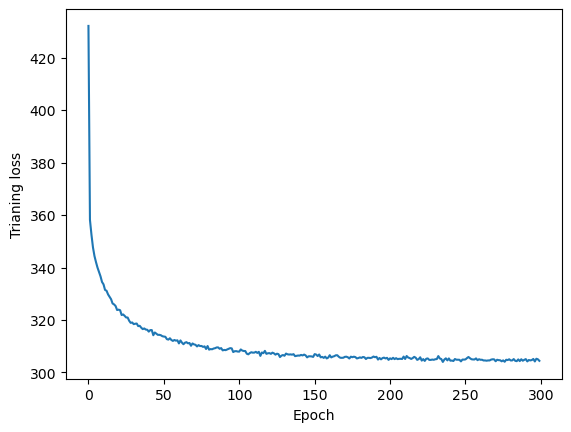

In [5]:
plt.plot(hist['train']['total'])
plt.xlabel('Epoch')
plt.ylabel('Trianing loss')

## Continue training saved models

We can continue training by specifying `init_epoch` and `num_epoch` arguments. Note that the value of `init_epoch` should depend on the number of epoch the latest checkpoint correponds to. 
As an example, above we have trained and saved the model at 300th epoch. So we can set `init_epoch=301` and increase the value of `num_epoch`.

In [6]:
hist = model.train(
        init_epoch=301, num_epoch=500, batch_size=512, save_every_epoch=50,
        verbose=True, checkpoint_dir=path_root+'checkpoint/')

Restored from result/test8/checkpoint/ckpt-6
Train - Start of epoch 301
60/60 [==============================] - 23s 388ms/step - Reconstructed Loss: 306.9844
Epoch 301, Time elapsed: 0.39 minutes
          total, obs_rna, obs_adt, obs_atac, unobs_rna, unobs_adt, unobs_atac,      kl,     mmd
train :  304.54,   55.97,   88.52,   23.68,   45.11,   70.46,   19.45,    1.33,    0.02
Train - Start of epoch 302
60/60 [==============================] - 10s 159ms/step - Reconstructed Loss: 304.6203
Epoch 302, Time elapsed: 0.55 minutes
          total, obs_rna, obs_adt, obs_atac, unobs_rna, unobs_adt, unobs_atac,      kl,     mmd
train :  304.31,   55.96,   88.52,   23.64,   45.12,   70.41,   19.30,    1.33,    0.02
Train - Start of epoch 303
60/60 [==============================] - 9s 157ms/step - Reconstructed Loss: 304.0151
Epoch 303, Time elapsed: 0.7 minutes
          total, obs_rna, obs_adt, obs_atac, unobs_rna, unobs_adt, unobs_atac,      kl,     mmd
train :  303.94,   55.99,   88.52,   

## Loading checkpoints

We load the model trained on 500 epochs:

In [7]:
# load the model and ensure it is loaded successfully
checkpoint = tf.train.Checkpoint(net=model.vae)
epoch = 10 # the latest checkpoint is 10 = 500/50 = num_epoch/save_every_epoch

status = checkpoint.restore(path_root+'checkpoint/ckpt-{}'.format(epoch))
model.vae(tf.zeros((1,np.sum(model.vae.config.dim_input_arr))),
          tf.zeros((1,np.sum(model.vae.config.dim_input_arr))),
          tf.zeros((1,np.sum(model.batches.shape[1]))), L=1, training=False)
print(status)

2024-08-17 17:56:44.047392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


# Obtain integrative latent representations

In [8]:
model.update_z()

In [9]:
# the latent variables are stored in model.adata
map_dict = {0:'Control',1:'Stimulation'}
condition = np.array([map_dict[i] for i in batches[:,0]])
map_dict = {0:'DOGMA-seq',1:'CITE-seq',2:'ASAP-seq'}
dataset = np.array([map_dict[i] for i in batches[:,-1]])

model.adata.obs['Condition'] = condition
model.adata.obs['Condition'] = model.adata.obs['Condition'].astype("category")
model.adata.obs['Dataset'] = dataset
model.adata.obs['Dataset'] = model.adata.obs['Dataset'].astype("category")
model.adata.obs['Cell Types'] = cell_types
model.adata

AnnData object with n_obs × n_vars = 30987 × 32
    obs: 'Condition', 'Dataset', 'Cell Types'
    uns: 'neighbors'
    obsp: 'distances', 'connectivities'

Calculate UMAP ...


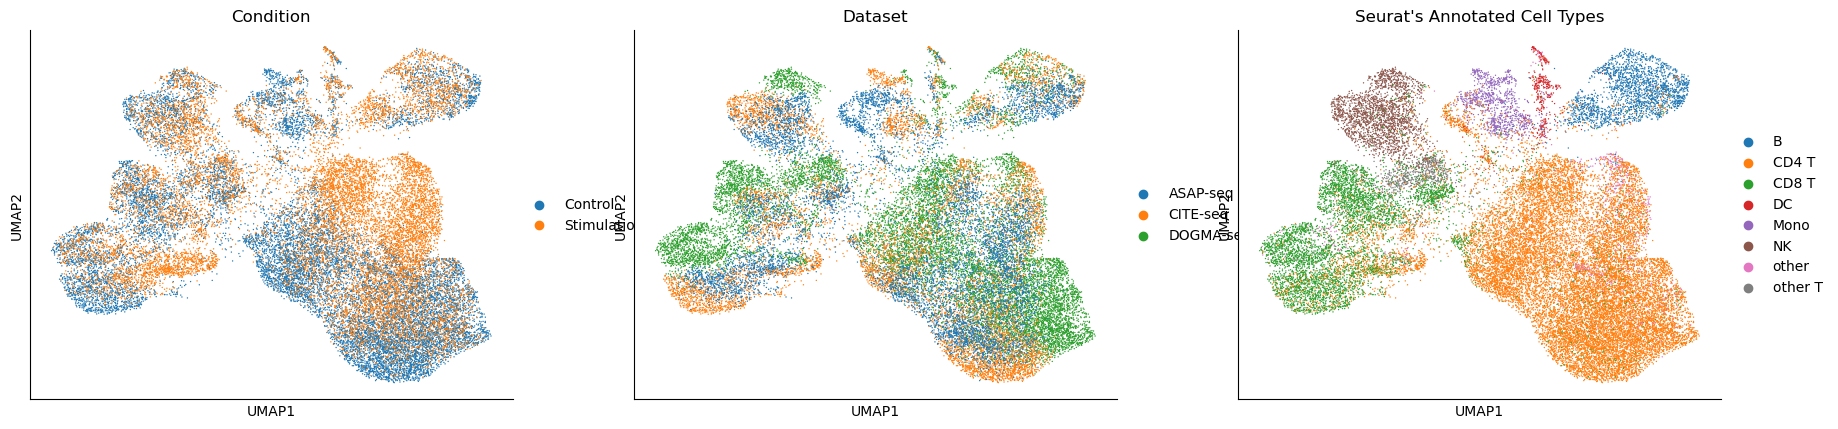

In [10]:
axes = model.visualize_latent(method = "UMAP", color = [
    'Condition','Dataset','Cell Types'], show=False)
axes[2].set_title("Seurat's Annotated Cell Types")

# Hide the right and top spines
axes[0].spines.right.set_visible(False)
axes[0].spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')

axes[1].spines.right.set_visible(False)
axes[1].spines.top.set_visible(False)
axes[1].yaxis.set_ticks_position('left')
# axes[0].xaxis.set_ticks_position('bottom')

axes[2].spines.right.set_visible(False)
axes[2].spines.top.set_visible(False)
axes[2].yaxis.set_ticks_position('left')
plt.show()

# Visualize the denoised and imputed expressions

In [11]:
denoised_data = model.get_denoised_data(
    batch_size_inference=128, L=50)

adata = sc.AnnData(
    X=pd.DataFrame(data[:,:model.vae.config.dim_input_arr[0]], columns=gene_names))

adata.uns = model.adata.uns
adata.obsm = model.adata.obsm
adata.obs = model.adata.obs

adata_hat = sc.AnnData(
    X=pd.DataFrame(denoised_data[:,:model.vae.config.dim_input_arr[0]], columns=gene_names))

adata_hat.uns = model.adata.uns
adata_hat.obsm = model.adata.obsm
adata_hat.obs = model.adata.obs

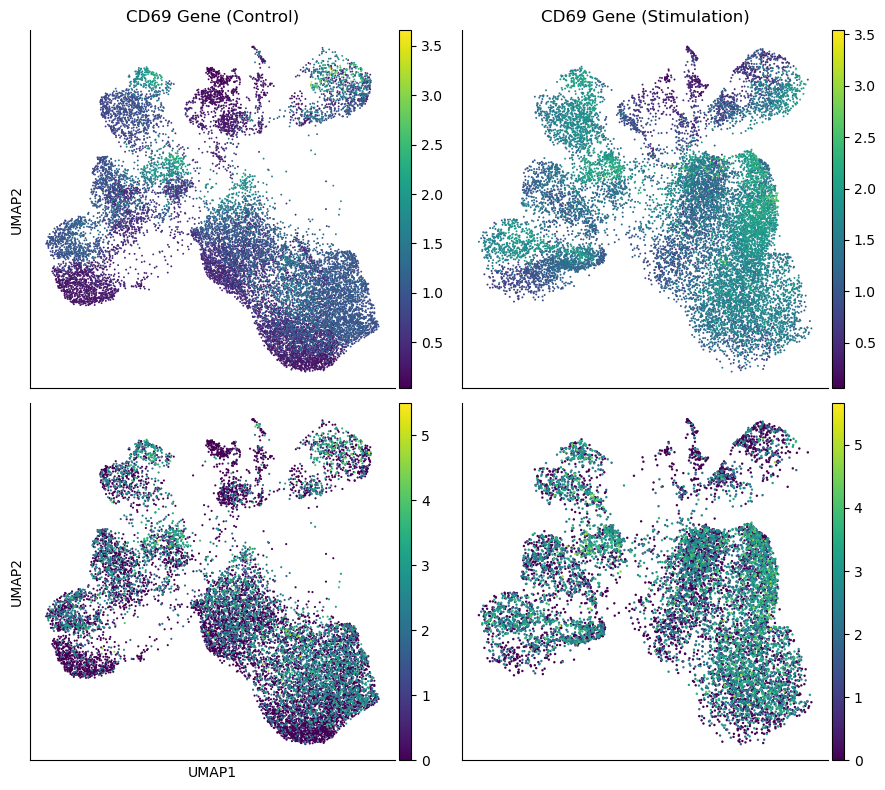

In [12]:
fig, axes = plt.subplots(2,2,figsize=(9,8))
sc.pl.umap(adata_hat[adata.obs['Condition']=='Control'], 
           color='CD69', ax=axes[0,0], show=False)
sc.pl.umap(adata_hat[adata.obs['Condition']!='Control'], 
           color='CD69', ax=axes[0,1], show=False)
sc.pl.umap(adata[(adata.obs['Dataset']!='ASAP-seq')&
    (adata.obs['Condition']=='Control')], 
           color='CD69', ax=axes[1,0], show=False)
sc.pl.umap(adata[(adata.obs['Dataset']!='ASAP-seq')&
    (adata.obs['Condition']!='Control')], 
           color='CD69', ax=axes[1,1], show=False)

for i in range(2):
    for j in range(2):
        
        # Hide the right and top spines
        axes[i,j].spines.right.set_visible(False)
        axes[i,j].spines.top.set_visible(False)

        # Only show ticks on the left and bottom spines
        axes[i,j].yaxis.set_ticks_position('left')
        axes[i,j].xaxis.set_ticks_position('bottom')
        
        axes[i,j].set_xlabel('')
        axes[i,j].set_ylabel('')
        axes[i,j].set_title('')
axes[1,0].set_xlabel('UMAP1')
axes[0,0].set_ylabel('UMAP2')
axes[1,0].set_ylabel('UMAP2')

axes[0,0].set_title('CD69 Gene (Control)')
axes[0,1].set_title('CD69 Gene (Stimulation)')

plt.tight_layout()

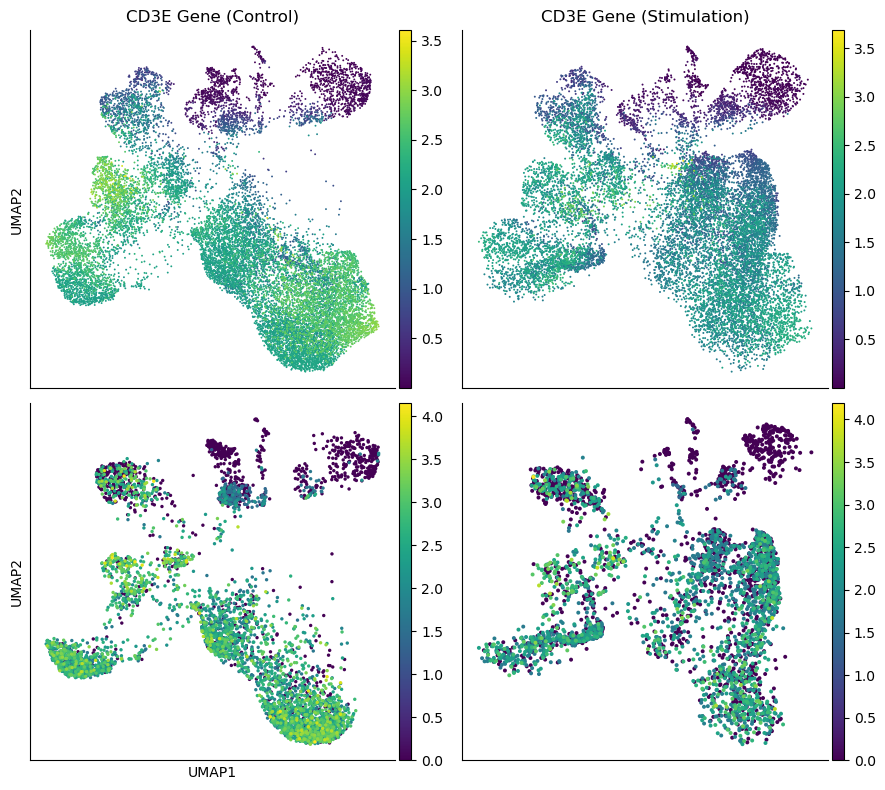

In [13]:
fig, axes = plt.subplots(2,2,figsize=(9,8))
sc.pl.umap(adata_hat[adata.obs['Condition']=='Control'], 
           color='CD3E', ax=axes[0,0], show=False)
sc.pl.umap(adata_hat[adata.obs['Condition']!='Control'], 
           color='CD3E', ax=axes[0,1], show=False)
sc.pl.umap(adata[(adata.obs['Dataset']=='CITE-seq')&
    (adata.obs['Condition']=='Control')], 
           color='CD3E', ax=axes[1,0], show=False)
sc.pl.umap(adata[(adata.obs['Dataset']=='CITE-seq')&
    (adata.obs['Condition']!='Control')], 
           color='CD3E', ax=axes[1,1], show=False)

for i in range(2):
    for j in range(2):
        
        # Hide the right and top spines
        axes[i,j].spines.right.set_visible(False)
        axes[i,j].spines.top.set_visible(False)

        # Only show ticks on the left and bottom spines
        axes[i,j].yaxis.set_ticks_position('left')
        axes[i,j].xaxis.set_ticks_position('bottom')
        
        axes[i,j].set_xlabel('')
        axes[i,j].set_ylabel('')
        axes[i,j].set_title('')
axes[1,0].set_xlabel('UMAP1')
axes[0,0].set_ylabel('UMAP2')
axes[1,0].set_ylabel('UMAP2')

axes[0,0].set_title('CD3E Gene (Control)')
axes[0,1].set_title('CD3E Gene (Stimulation)')

plt.tight_layout()
plt.show()